# Q3 Short Video Classification

In [4]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np
import cv2
import math

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tqdm import tqdm

## 1. Load Data

### 1.1 Train Tag Data

In [18]:
train_tag = pd.read_csv('Data_Q3/tarin_tag.txt', sep=",", header=None)
train_tag.columns = ["video", "tag"]

# Find all unque labels
unique_labels = train_tag['tag'].unique()

# label dict to int
label_map = {label: idx for idx, label in enumerate(unique_labels)}
train_tag['tag'] = train_tag['tag'].map(label_map)

# num of unique labels
num_classes = len(unique_labels)
print(f"Class number: {num_classes}")

Class number: 15


In [22]:
train_tag

,video,tag
0,873879927.mp4,0
1,872438072.mp4,0
2,796902701_219_229.mp4,1
3,829923135_39_49.mp4,1
4,859022208.mp4,0
...,...,...
2058,304035088.mp4,10
2059,303734394.mp4,10
2060,892673978.mp4,0
2061,613605247.mp4,9


In [23]:
# Count the sample size for each category
class_counts = train_tag['tag'].value_counts()
print(class_counts)

tag
9     328
1     224
11    157
13    157
6     155
0     144
4     130
5     129
3     108
14    108
12     98
2      90
7      79
10     79
8      77
Name: count, dtype: int64


### 1.2 Vedio Data

In [24]:
# Modify load_ MP4 function to adapt to multi-threaded loading of video data
def load_mp4(file_path, img_size, frames):
    cap = cv2.VideoCapture(file_path)
    video_frames = []
    for _ in range(frames):
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (img_size[0], img_size[1]))
            frame = np.transpose(frame, (2, 0, 1)) 
            video_frames.append(frame)
        else:
            break
    cap.release()
    return video_frames

path = 'Data_Q3//train_video//'
x = []
y = []

img_size = (64, 64, 3)
frames = 20

In [25]:
# Use multithreading to load video data
def process_video(filename):
    if filename.endswith(".mp4"):
        v = load_mp4(path + filename, img_size, frames)
        tag = train_tag['tag'][train_tag['video'] == filename].values[0]
        return v, tag

# Loading video data with multiple threads
with ThreadPoolExecutor() as executor:
    future_to_file = {executor.submit(process_video, filename): filename for filename in os.listdir(path)}

    completed_count = 0
    for future in tqdm(as_completed(future_to_file), total=len(future_to_file)):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                x.append(result[0])
                y.append(result[1])
            completed_count += 1
#             print(f"Processed {completed_count}/{len(future_to_file)} videos")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

#         if len(x) == size:
#             break

print("Video processing completed.")


100%|██████████████████████████████████████████████████████████████████████████████| 2063/2063 [00:38<00:00, 53.01it/s]

Video processing completed.


In [26]:
x=np.array(x)
x.shape

(2063, 20, 3, 64, 64)

In [27]:
y=np.array(y)
y.shape

(2063,)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (1650, 20, 3, 64, 64)
y_train shape: (1650,)
x_val shape: (413, 20, 3, 64, 64)
y_val shape: (413,)


In [29]:
def show_data(index, x, y):
    print('label: ', y[index])
    plt.figure(figsize=(20, 10))
    columns = 5
    images = x[index]
    print('shape: ', images.shape)
    rows = math.ceil(len(images) / columns)  # Calculate the number of rows and convert the result to an integer using math.ceil
    for i, image in enumerate(images):
        # Rearrange the dimensions of the image to meet the requirements of the imshow function
        image = np.transpose(image, (1, 2, 0))  # (3, 64, 64) --> (64, 64, 3)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)

label:  9
shape:  (20, 3, 64, 64)


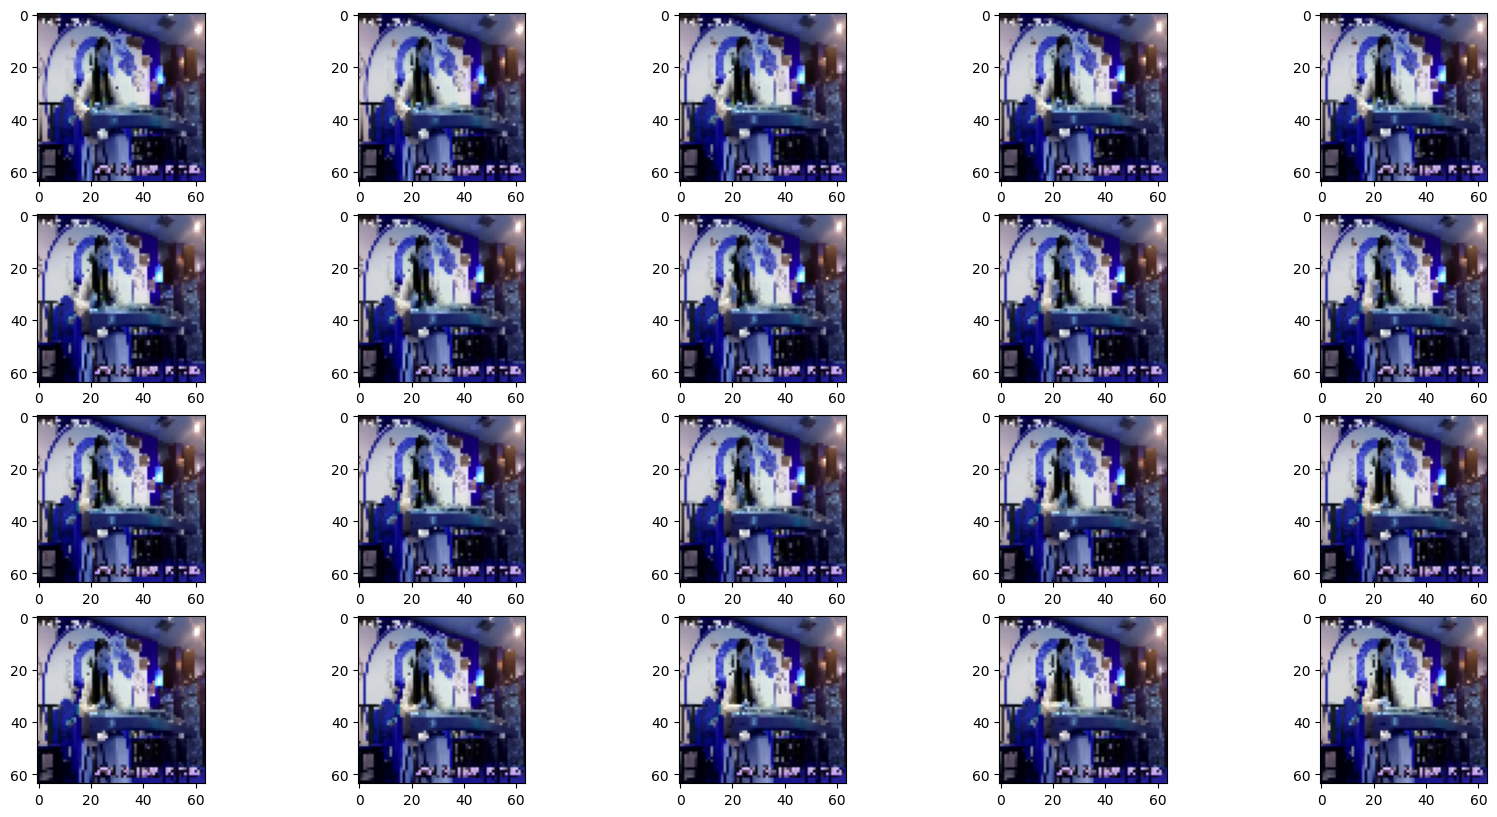

In [30]:
show_data(39, x_train, y_train)

## 2. Model

### 2.1. 3D Convolution

#### (1) Model Structure

In [31]:
class VideoClassifier_3D(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier_3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.fc1 = nn.Linear(8192, 128)  # Adjust the input size to match the length of the flattened feature
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # The shape of x: (batch_size, channels, numframes, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        #print(x.shape)  # Check the flattened shape of the features here
        x = x.view(x.size(0), -1)  # Flatten features into one-dimensional vectors
        #print(x.shape)  # Print the shape of x again to ensure it matches the input shape of self.fc1
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 实例化模型
model = VideoClassifier_3D(num_classes=num_classes)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(20, 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 20, 64, 64]           1,312
              ReLU-2       [-1, 16, 20, 64, 64]               0
         MaxPool3d-3       [-1, 16, 10, 32, 32]               0
            Conv3d-4       [-1, 32, 10, 32, 32]          13,856
              ReLU-5       [-1, 32, 10, 32, 32]               0
         MaxPool3d-6        [-1, 32, 5, 16, 16]               0
            Conv3d-7        [-1, 64, 5, 16, 16]          55,360
              ReLU-8        [-1, 64, 5, 16, 16]               0
         MaxPool3d-9          [-1, 64, 2, 8, 8]               0
           Linear-10                  [-1, 128]       1,048,704
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 15]           1,935
Total params: 1,121,167
Trainable params: 1,121,167
Non-trainable params: 0
---------------------------

#### (2) Data Preparation

In [33]:
# Convert data to Tensor type of PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create a data loader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Defining loss functions and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([1650, 20, 3, 64, 64])
torch.Size([1650])
torch.Size([413, 20, 3, 64, 64])
torch.Size([413])


In [34]:
# Define lists to store training and validation losses
output_model_path = "Q4_model_3dConv.bin"

train_losses = []

train_accuracies = []
val_accuracies = []

epochs = 32

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{32}', leave=False)
    
    for batch in progress_bar:
        input_ids = batch[0]
        labels = batch[1]
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    
    # Calculate average training loss and accuracy for the epoch
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluation on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:  # Assuming you have a val_loader for validation set
            val_outputs = model(val_inputs)

            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

        
    # Calculate average validation loss and accuracy for the epoch
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")
    # Save the model if needed
    torch.save(model.state_dict(), output_model_path)

Epoch 1/32 - Train Loss: 2.946170515739001 - Train Acc: 20.73% - Val Acc: 21.07%


Epoch 2/32 - Train Loss: 2.126093999697612 - Train Acc: 33.33% - Val Acc: 23.24%


Epoch 3/32 - Train Loss: 1.7942442275010622 - Train Acc: 43.82% - Val Acc: 34.87%


Epoch 4/32 - Train Loss: 1.4856694059876294 - Train Acc: 53.21% - Val Acc: 36.80%


Epoch 5/32 - Train Loss: 1.232244095263573 - Train Acc: 60.48% - Val Acc: 36.08%


Epoch 6/32 - Train Loss: 0.9705043773238475 - Train Acc: 69.09% - Val Acc: 40.92%


Epoch 7/32 - Train Loss: 0.6667501041128372 - Train Acc: 79.03% - Val Acc: 34.14%


Epoch 8/32 - Train Loss: 0.4361351222659533 - Train Acc: 86.36% - Val Acc: 40.92%


Epoch 9/32 - Train Loss: 0.2946747831033113 - Train Acc: 90.61% - Val Acc: 39.47%


Epoch 10/32 - Train Loss: 0.19118125747235565 - Train Acc: 94.36% - Val Acc: 41.65%


Epoch 11/32 - Train Loss: 0.2702130829073632 - Train Acc: 91.82% - Val Acc: 38.50%


Epoch 12/32 - Train Loss: 0.2921930141142531 - Train Acc: 92.42% - Val Acc: 41.89%


Epoch 13/32 - Train Loss: 0.12147951053115182 - Train Acc: 96.73% - Val Acc: 40.92%


Epoch 14/32 - Train Loss: 0.2232346684188367 - Train Acc: 94.12% - Val Acc: 41.16%


Epoch 15/32 - Train Loss: 0.18711436557126804 - Train Acc: 94.12% - Val Acc: 37.05%


Epoch 16/32 - Train Loss: 0.17279112940377672 - Train Acc: 94.48% - Val Acc: 40.19%


Epoch 17/32 - Train Loss: 0.059075533228539055 - Train Acc: 98.30% - Val Acc: 42.86%


Epoch 18/32 - Train Loss: 0.06549799513735567 - Train Acc: 98.18% - Val Acc: 40.44%


Epoch 19/32 - Train Loss: 0.033018777170617304 - Train Acc: 99.15% - Val Acc: 43.34%


Epoch 20/32 - Train Loss: 0.04671748278706918 - Train Acc: 98.85% - Val Acc: 42.86%


Epoch 21/32 - Train Loss: 0.11365446336577197 - Train Acc: 97.39% - Val Acc: 39.47%


Epoch 22/32 - Train Loss: 0.19258483485632147 - Train Acc: 94.67% - Val Acc: 40.68%


Epoch 23/32 - Train Loss: 0.16233321336151746 - Train Acc: 95.27% - Val Acc: 34.62%


Epoch 24/32 - Train Loss: 0.06375022219967483 - Train Acc: 98.12% - Val Acc: 41.16%


Epoch 25/32 - Train Loss: 0.014150669103313017 - Train Acc: 99.58% - Val Acc: 43.10%


Epoch 26/32 - Train Loss: 0.009501956631239658 - Train Acc: 99.76% - Val Acc: 44.79%


Epoch 27/32 - Train Loss: 0.0073505650439475816 - Train Acc: 99.76% - Val Acc: 44.55%


Epoch 28/32 - Train Loss: 0.00561645641052713 - Train Acc: 99.76% - Val Acc: 44.31%


Epoch 29/32 - Train Loss: 0.007090178141712482 - Train Acc: 99.76% - Val Acc: 44.31%


Epoch 30/32 - Train Loss: 0.007704861721966092 - Train Acc: 99.70% - Val Acc: 44.07%


Epoch 31/32 - Train Loss: 0.005406787479721778 - Train Acc: 99.82% - Val Acc: 43.34%


Epoch 32/32 - Train Loss: 0.005743895891580582 - Train Acc: 99.88% - Val Acc: 44.31%


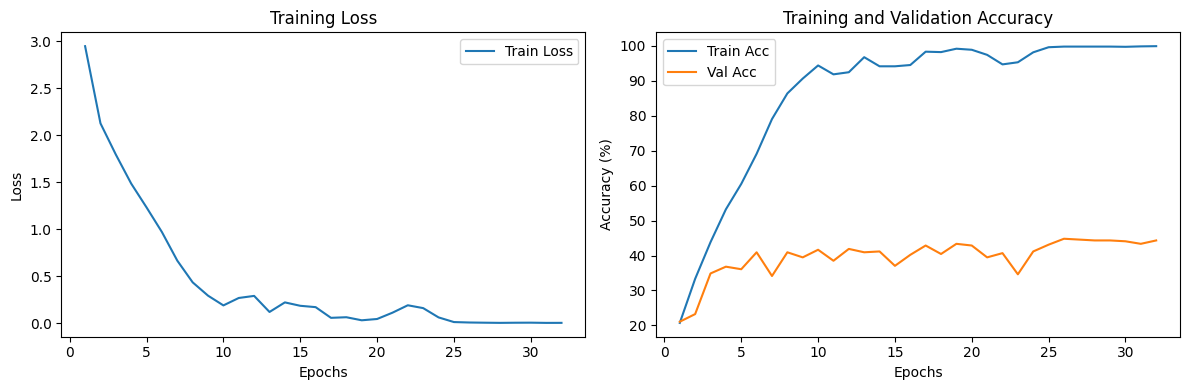

In [35]:
# Plotting the training history - Losses and Accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 2.2. 2D Convolution 

In [21]:
class VideoClassifier_2D(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier_2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size, num_frames, channels, height, width = x.size()
        x = x.view(batch_size * num_frames, channels, height, width)  # Flatten the video frames first
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(batch_size, num_frames, -1)  # Reshape to (batch_size, numframes, features)
        x = x.mean(dim=1)  
        x = self.relu(self.fc1(x)) # Average the frame features in each sample to obtain video features
        x = self.fc2(x)
        return x

# Instantiating models
model = VideoClassifier_2D(num_classes=num_classes)

In [22]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(20, 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Linear-10                  [-1, 128]         524,416
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 15]           1,935
Total params: 549,935
Trainable params: 549,935
Non-trainable params: 0
-------------------------------

In [38]:
# Convert data to Tensor type of PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create a data loader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Defining loss functions and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

torch.Size([1650, 20, 3, 64, 64])
torch.Size([1650])
torch.Size([413, 20, 3, 64, 64])
torch.Size([413])


In [39]:
# Define lists to store training and validation losses
output_model_path = "Q4_model_2dConv.bin"

train_losses = []

train_accuracies = []
val_accuracies = []

epochs = 32

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{32}', leave=False)
    
    for batch in progress_bar:
        input_ids = batch[0]
        labels = batch[1]
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    
    # Calculate average training loss and accuracy for the epoch
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluation on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:  # Assuming you have a val_loader for validation set
            val_outputs = model(val_inputs)

            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

        
    # Calculate average validation loss and accuracy for the epoch
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")
    # Save the model if needed
    torch.save(model.state_dict(), output_model_path)

Epoch 1/32 - Train Loss: 2.684557955998641 - Train Acc: 18.73% - Val Acc: 20.10%


Epoch 2/32 - Train Loss: 2.1986863085856805 - Train Acc: 30.73% - Val Acc: 36.32%


Epoch 3/32 - Train Loss: 1.9595706978669534 - Train Acc: 38.30% - Val Acc: 38.50%


Epoch 4/32 - Train Loss: 1.662528079432937 - Train Acc: 46.85% - Val Acc: 41.89%


Epoch 5/32 - Train Loss: 1.4019074892768493 - Train Acc: 57.52% - Val Acc: 40.68%


Epoch 6/32 - Train Loss: 1.1535293124616146 - Train Acc: 64.61% - Val Acc: 40.68%


Epoch 7/32 - Train Loss: 0.943025392981676 - Train Acc: 70.61% - Val Acc: 46.73%


Epoch 8/32 - Train Loss: 0.7109375530137465 - Train Acc: 78.61% - Val Acc: 44.55%


Epoch 9/32 - Train Loss: 0.570010367136162 - Train Acc: 82.36% - Val Acc: 47.46%


Epoch 10/32 - Train Loss: 0.3616810281975911 - Train Acc: 88.36% - Val Acc: 47.70%


Epoch 11/32 - Train Loss: 0.2839420201937453 - Train Acc: 91.15% - Val Acc: 48.18%


Epoch 12/32 - Train Loss: 0.27217797200696975 - Train Acc: 90.97% - Val Acc: 44.07%


Epoch 13/32 - Train Loss: 0.155024612746694 - Train Acc: 95.09% - Val Acc: 45.28%


Epoch 14/32 - Train Loss: 0.1113586686137401 - Train Acc: 96.30% - Val Acc: 43.34%


Epoch 15/32 - Train Loss: 0.07477359448799129 - Train Acc: 97.82% - Val Acc: 43.58%


Epoch 16/32 - Train Loss: 0.18394200871094094 - Train Acc: 94.24% - Val Acc: 42.13%


Epoch 17/32 - Train Loss: 0.2664921269035683 - Train Acc: 92.24% - Val Acc: 40.92%


Epoch 18/32 - Train Loss: 0.206607415137114 - Train Acc: 93.88% - Val Acc: 42.86%


Epoch 19/32 - Train Loss: 0.14802627489105083 - Train Acc: 95.82% - Val Acc: 42.37%


Epoch 20/32 - Train Loss: 0.1802850394261231 - Train Acc: 95.88% - Val Acc: 40.92%


Epoch 21/32 - Train Loss: 0.37217224582743186 - Train Acc: 89.64% - Val Acc: 45.76%


Epoch 22/32 - Train Loss: 0.062119544200798446 - Train Acc: 98.06% - Val Acc: 47.70%


Epoch 23/32 - Train Loss: 0.058558577358780894 - Train Acc: 98.30% - Val Acc: 47.70%


Epoch 24/32 - Train Loss: 0.04302344961326281 - Train Acc: 98.42% - Val Acc: 48.67%


Epoch 25/32 - Train Loss: 0.039513748691696 - Train Acc: 99.09% - Val Acc: 46.25%


Epoch 26/32 - Train Loss: 0.02487784041358929 - Train Acc: 99.21% - Val Acc: 47.46%


Epoch 27/32 - Train Loss: 0.013233616085472022 - Train Acc: 99.70% - Val Acc: 48.91%


Epoch 28/32 - Train Loss: 0.008163489600147063 - Train Acc: 99.76% - Val Acc: 48.67%


Epoch 29/32 - Train Loss: 0.009183248898886212 - Train Acc: 99.70% - Val Acc: 48.43%


Epoch 30/32 - Train Loss: 0.007225286210025563 - Train Acc: 99.76% - Val Acc: 48.43%


Epoch 31/32 - Train Loss: 0.007138503651479875 - Train Acc: 99.76% - Val Acc: 48.67%


Epoch 32/32 - Train Loss: 0.007188787579239558 - Train Acc: 99.76% - Val Acc: 48.91%


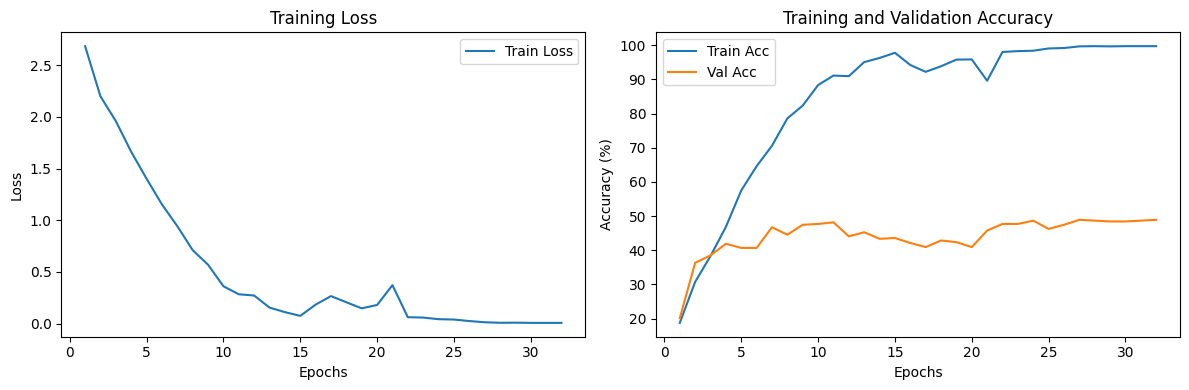

In [40]:
# Plotting the training history - Losses and Accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Model Application on Test set

In [5]:
def load_mp4(file_path, img_size, frames):
    cap = cv2.VideoCapture(file_path)
    video_frames = []
    for _ in range(frames):
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (img_size[0], img_size[1]))
            frame = np.transpose(frame, (2, 0, 1)) 
            video_frames.append(frame)
        else:
            break
    cap.release()
    return video_frames

path = 'Data_Q3//test_video//'
file = []
x = []

img_size = (64, 64, 3)
frames = 20

In [6]:
# Use multithreading to load video data
def process_video(filename):
    if filename.endswith(".mp4"):
        v = load_mp4(path + filename, img_size, frames)
        return v,filename

with ThreadPoolExecutor() as executor:
    future_to_file = {executor.submit(process_video, filename): filename for filename in os.listdir(path)}

    completed_count = 0
    for future in tqdm(as_completed(future_to_file), total=len(future_to_file)):
        filename = future_to_file[future]
        try:
            result = future.result()
            if result is not None:
                x.append(result[0])
                file.append(result[1])
            completed_count += 1
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Video processing completed.")

100%|████████████████████████████████████████████████████████████████████████████████| 562/562 [00:10<00:00, 52.64it/s]

Video processing completed.


In [7]:
x=np.array(x)
x.shape

(562, 20, 3, 64, 64)

In [17]:
print(type(file))
print(len(file))

<class 'list'>
562


In [11]:
def show_test_data(index, x, file):
    print(f"testfile:{file[index]}")
    plt.figure(figsize=(20, 10))
    columns = 5
    images = x[index]
    print('shape: ', images.shape)
    rows = math.ceil(len(images) / columns)
    for i, image in enumerate(images):
        # Rearrange the dimensions of the image to meet the requirements of the imshow function
        image = np.transpose(image, (1, 2, 0))  # 3, 64, 64) -> (64, 64, 3)
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)

testfile:333014934.mp4
shape:  (20, 3, 64, 64)


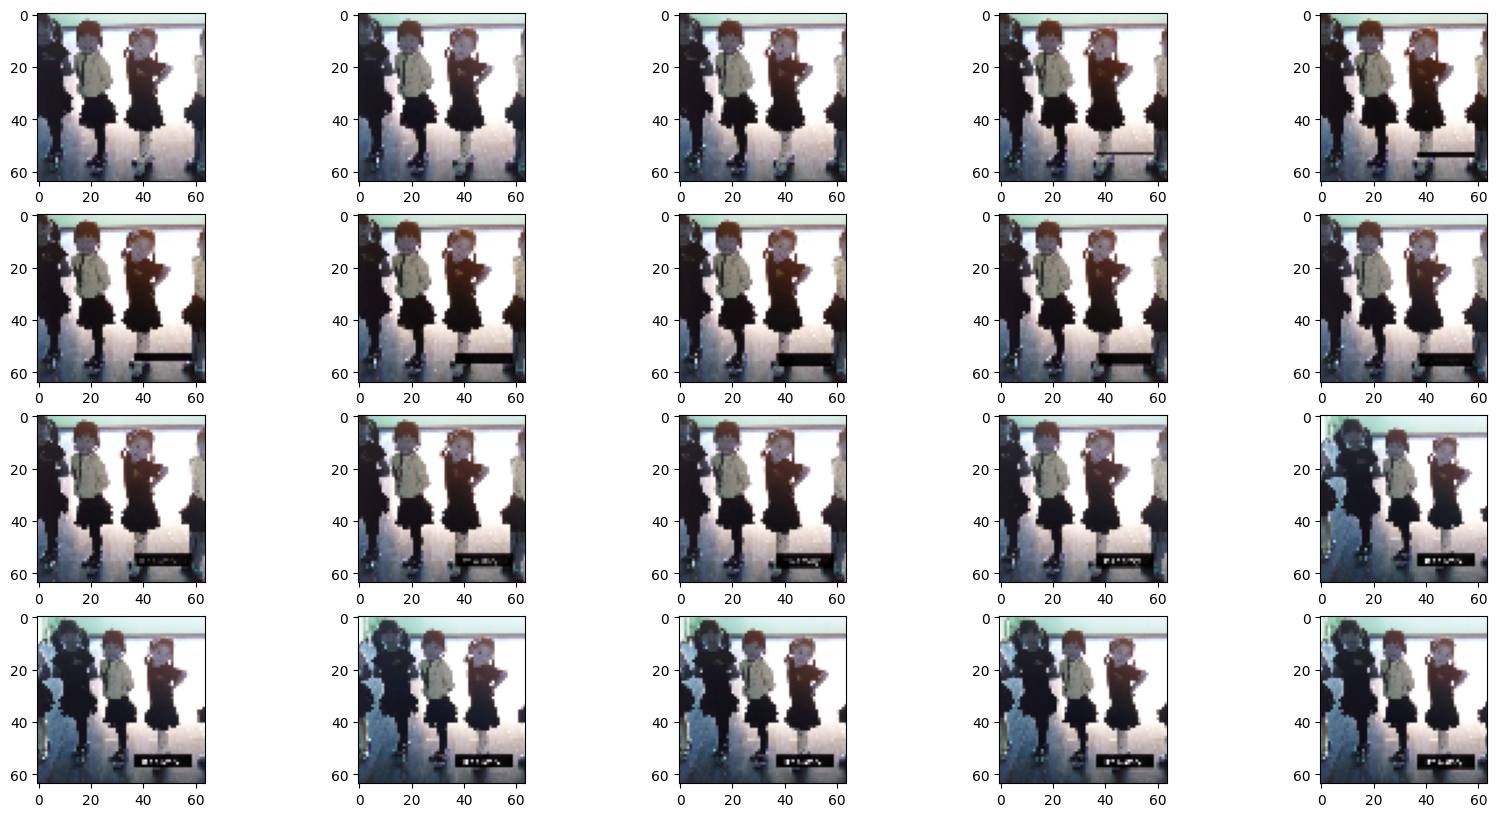

In [13]:
show_test_data(22,x,file)

In [19]:
# Convert test data to PyTorch TensorDataset
x_test_tensor = torch.tensor(x, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor)

# Create a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
model_path = "Q4_model_2dConv.bin"

# Load the trained model
model = VideoClassifier_2D(num_classes=num_classes)  # num_class = 15
model.load_state_dict(torch.load(model_path))  # Load the trained model
model.eval()  # Set the model to evaluation mode

# Make predictions on the test set
predictions = []
with torch.no_grad():
    for inputs in tqdm(test_loader, desc='Predicting', leave=False):
        outputs = model(inputs[0])  # Assuming the input index is 0
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [25]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({'file_name': file, 'label': predictions})
results_df

,file_name,label
0,304037982.mp4,13
1,303746162.mp4,6
2,303942687.mp4,0
3,30018754.mp4,2
4,304078846.mp4,2
...,...,...
557,897551456.mp4,12
558,898969484_32_42.mp4,4
559,899183470.mp4,9
560,899865823.mp4,3


In [26]:
# Save results to CSV
results_df.to_csv('Q3_output.csv', index=False)